# Exercices

## **Préliminaires**: Clone de votre repo et imports

In [1]:
# ! git clone https://github.com/XXXXXXX/exam_2025_session2.git
# ! cp exam_2025_session2/utils/utils.py .

import copy
import numpy as np
import torch
import matplotlib.pyplot as plt


In [18]:
# fonctions utiles pour l'ensemble des exercices:
! git clone https://github.com/nanopiero/ML_S5_etudiants
import sys
sys.path.append('ML_S5_etudiants/practicals/P5')
from utils_P5 import gen_proba, voir_batch2D, UNet, make_batch

def gen_dr(n):
  discs = make_batch(n, rec = 0., noisy_rec= 0., disc = 0.0003)
  rectangles = make_batch(n, rec = 0.002, noisy_rec= 0., disc = 0.)
  ideal_targets = rectangles > 0
  rectangles[discs > 0 ] = discs[discs > 0]
  return  rectangles, ideal_targets


def gen_d(n):
  discs = make_batch(n, rec = 0., noisy_rec= 0., disc = 0.0003)
  return  discs

def gen_ex2(n):
  target1 = make_batch(n, rec = 0., noisy_rec= 0., disc = 0.0015)
  target2 = make_batch(n, rec = 0.0015, noisy_rec= 0.0015, disc = 0.)
  target = 100 * target1.mean(dim=(1,2,3))
  print(target)
  m = torch.normal(target, 1.)
  input = target1 + target2
  target = m
  return  input, target

def gen_dr_train(n):
  discs = make_batch(n, rec = 0., noisy_rec= 0., disc = 0.0005)
  rectangles = make_batch(n, rec = 0.0005, noisy_rec= 0.0005, disc = 0.)
  targets = rectangles
  inputs = rectangles + discs
  return  inputs, targets

def gen_dr_test(n):
  discs = make_batch(n, rec = 0., noisy_rec= 0., disc = 0.002)
  rectangles = make_batch(n, rec = 0.001, noisy_rec= 0.001, disc = 0.)
  targets = rectangles
  inputs = rectangles + discs
  return  inputs, targets

fatal: destination path 'ML_S5_etudiants' already exists and is not an empty directory.


\

---

\

\

**Exercice 1** *Une segmentation dans un contexte faiblement supervisé*

La fonction *gen_dr* fournit permet de synthétiser des disques mêlés à des rectangles. Ici, les disques sont considérés comme du bruit, et le processus de corruption non en une somme (image = image_disques + image_rectangles) mais en une substitution (voir ci-dessous).
Elle fournit aussi une cible idéale, qui, en pratique, n'est pas disponible.


In [ ]:
input, ideal_targets = gen_dr(6)
# Inputs
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# ideal targets
fig1 = plt.figure(0, figsize=(36, 6))
voir_batch2D(ideal_targets, 6, fig1, k=0, min_scale=0,max_scale=1)

On dispose aussi d'une fonction *gen_d* qui synthétise des images comportant des disques :

In [ ]:
discs = gen_d(6)
# Discs
fig2 = plt.figure(0, figsize=(36, 6))
voir_batch2D(discs, 6, fig2, k=0, min_scale=0,max_scale=1)


**Q1** Rappeler ce qu'est la supervision faible. En quoi ce problème peut-il entrer dans cette catégorie ?

**Q2** Utiliser un UNet pour dire, pour une image produite par gen_dr, où sont les pixels qui étaient affectés par des rectangles **avant** corruption. Entraînez-le sur une cinquantaine d'époques. Utilisez la cible idéale pour contrôler la convergence. Visualiser quelques sorties après entraînement. Commentez.

\

**Exercice 2** *Une régression quantile*

La fonction *gen_ex2* permet de synthétiser des entrées / cibles à la volée :  




In [ ]:
# sampling (x,y) :

inputs, targets = gen_ex2(6)
# Inputs
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(inputs, 6, fig0, k=0, min_scale=0,max_scale=1)

# Targets
print(targets)

**Q1** Définir un Loader à partir du Dataset précédent (2 workers)

**Q2** Entraîner un ResNet18 à prédire la médiane conditionnelle à l'image d'entrée. Justifier l'absence d'une étape de validation.

In [ ]:
from torchvision.models import resnet18

...

**Q3** Modifier votre ResNet18 de manière à prédire aussi les premier et troisième quartiles. Préciser le nom de la fonction de coût utilisée.

**Q4** Après entraînement, évaluer les écarts interquartiles sur un batch de taille 64. Ces écarts semblent-ils dépendre de l'image d'entrée ?

**Q5 (Bonus)** On fait l'hypothèse que la sortie ne dépend que des disques. On suppose aussi qu'on ait accès, comme à l'exercice 1 à un jeu de données d'images ne comportant que des disques (fonction gen_d). Que feriez-vous pour tester cette hypothèse ? Répondez sans code, mais avec précision.

\

---

\

**Exercice 3** *Nettoyage et adaptation de domaine*

Comme à l'exercice 1, les disques sont considérés comme du bruit. Mais par contre, il s'agit d'une tâche de nettoyage et on se place dans le cas où des entrées et des cibles idéales sont disponibles en grand nombre à l'entraînement (fonction *gen_dr_train*).

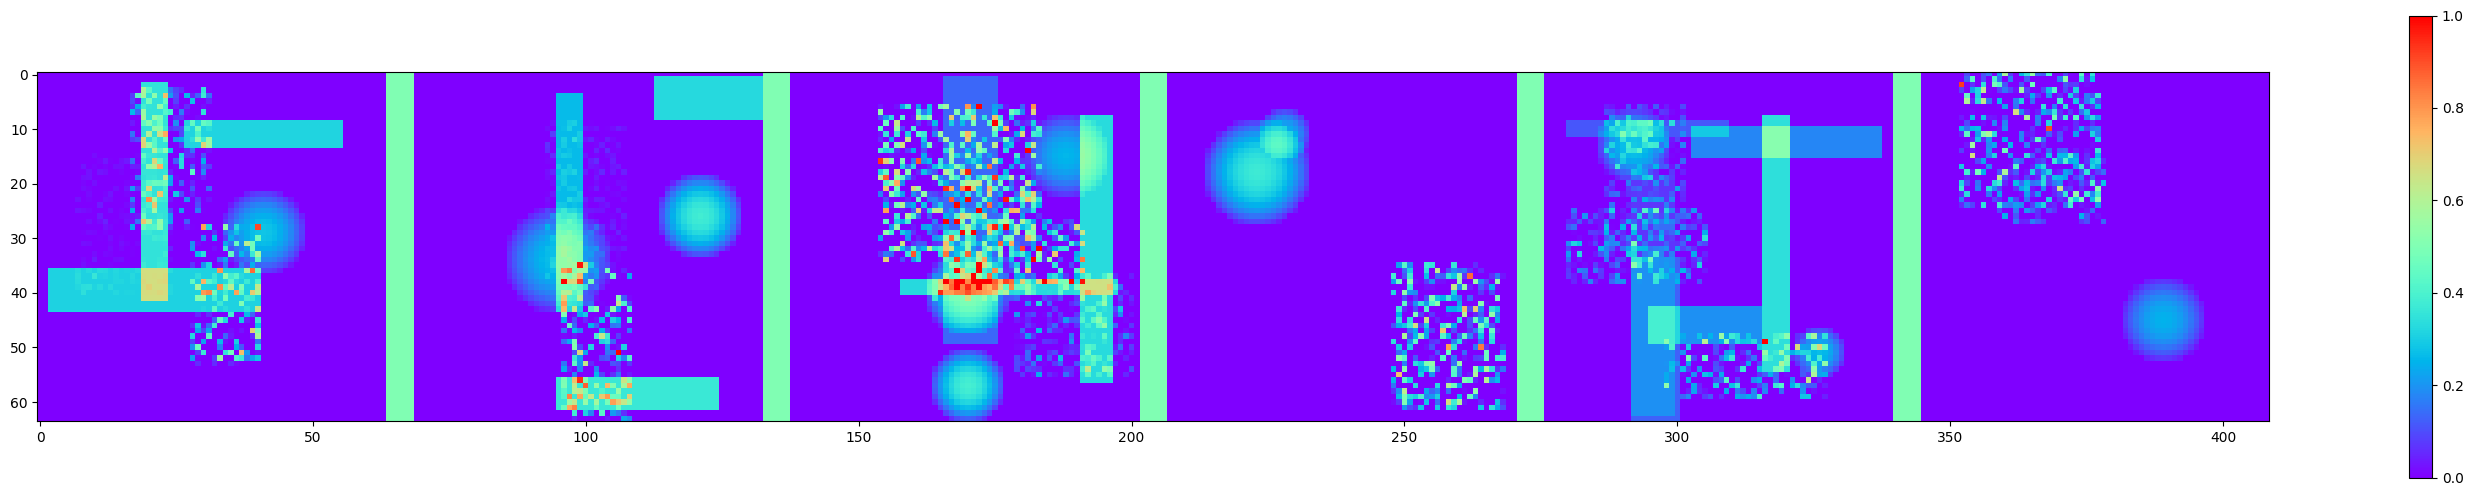

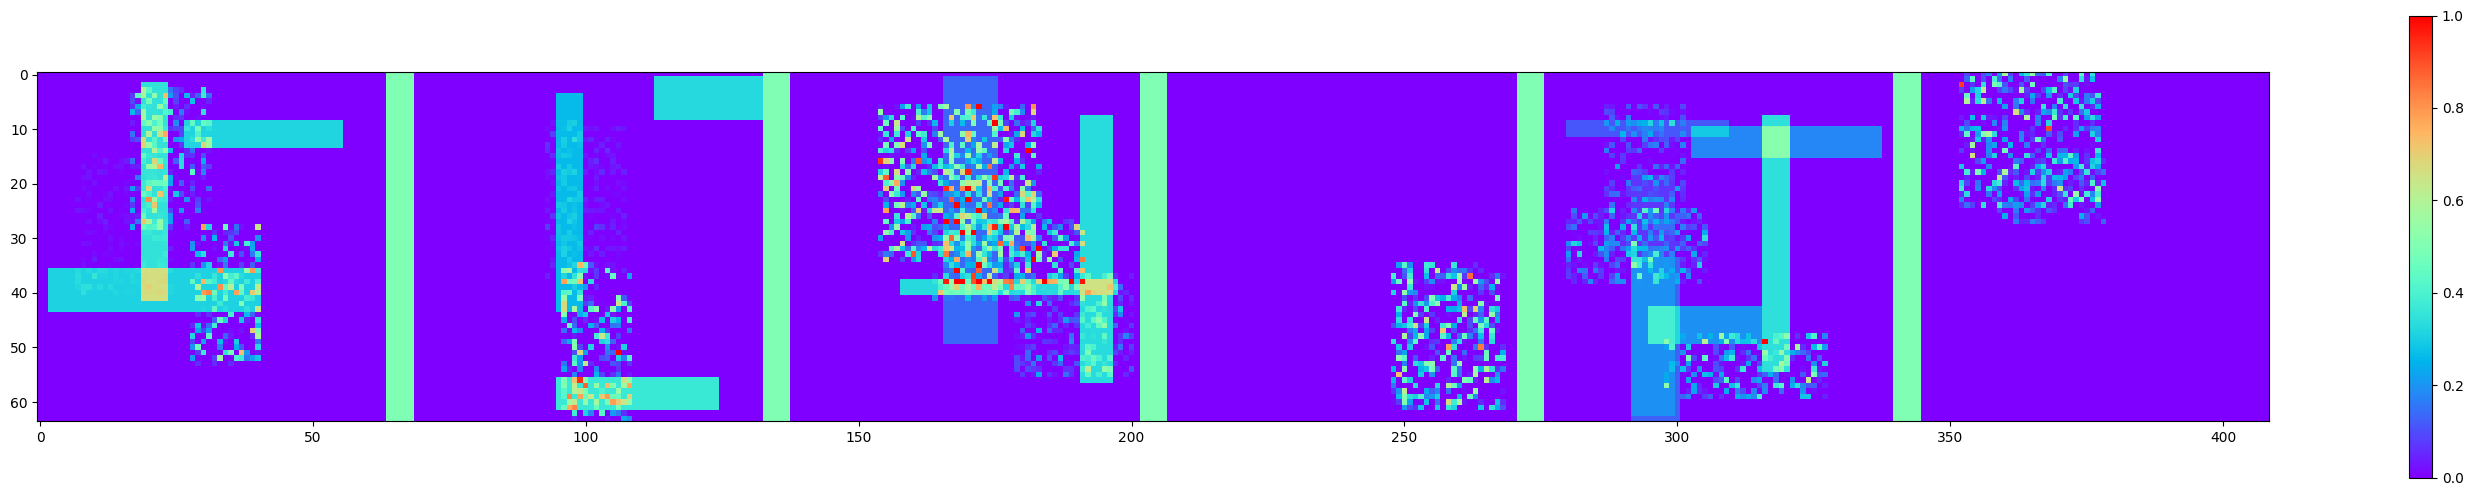

In [30]:
input, targets = gen_dr_train(6)
# Inputs (train)
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# targets (train)
fig1 = plt.figure(0, figsize=(36, 6))
voir_batch2D(targets, 6, fig1, k=0, min_scale=0,max_scale=1)

Par contre, on suppose que les images disponibles à l'entraînement ne suivent pas les mêmes statistiques que les données test, échantillonnables avec la fonction gen_dr_test suivante :

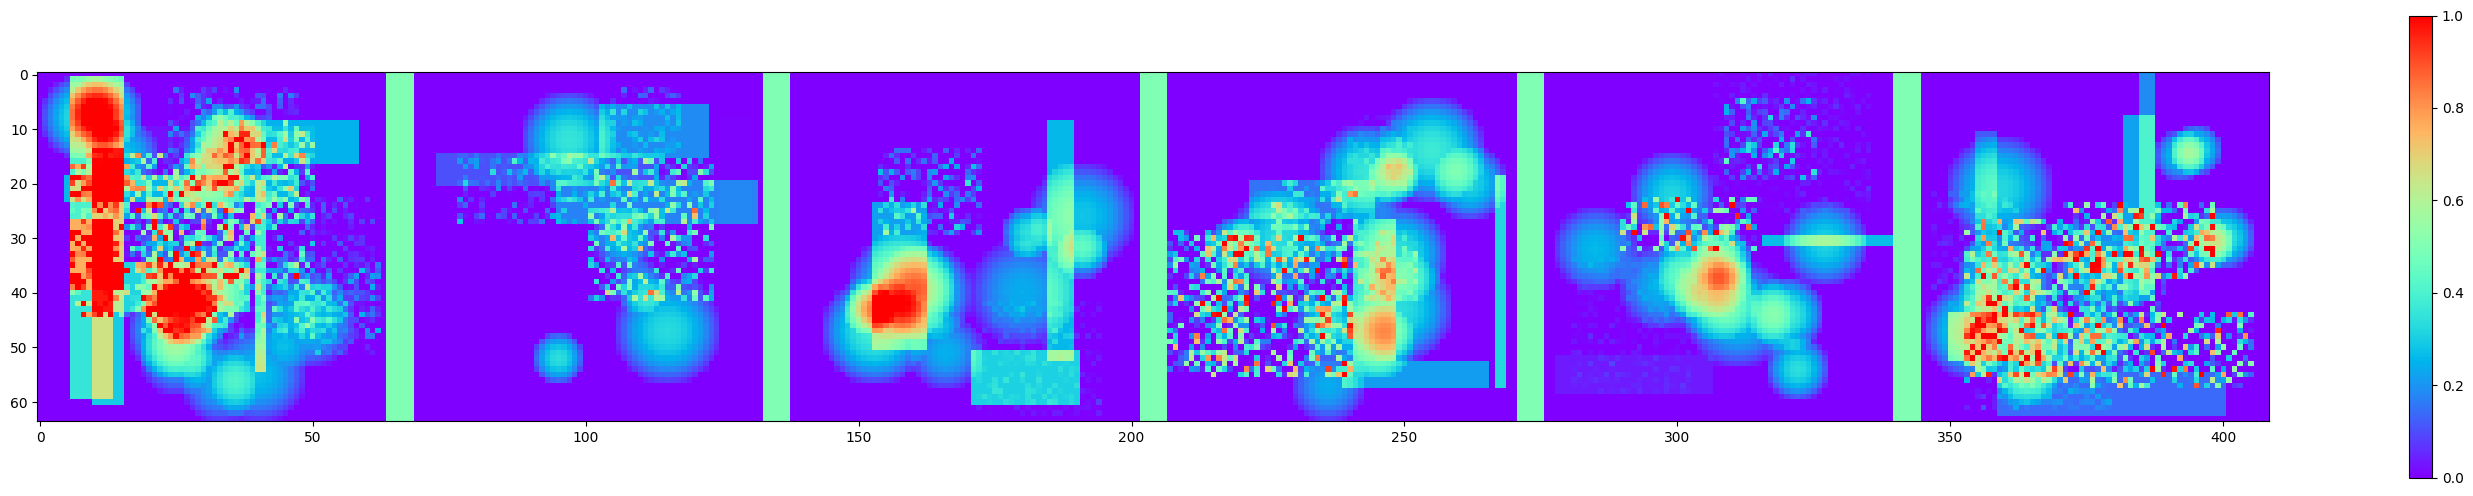

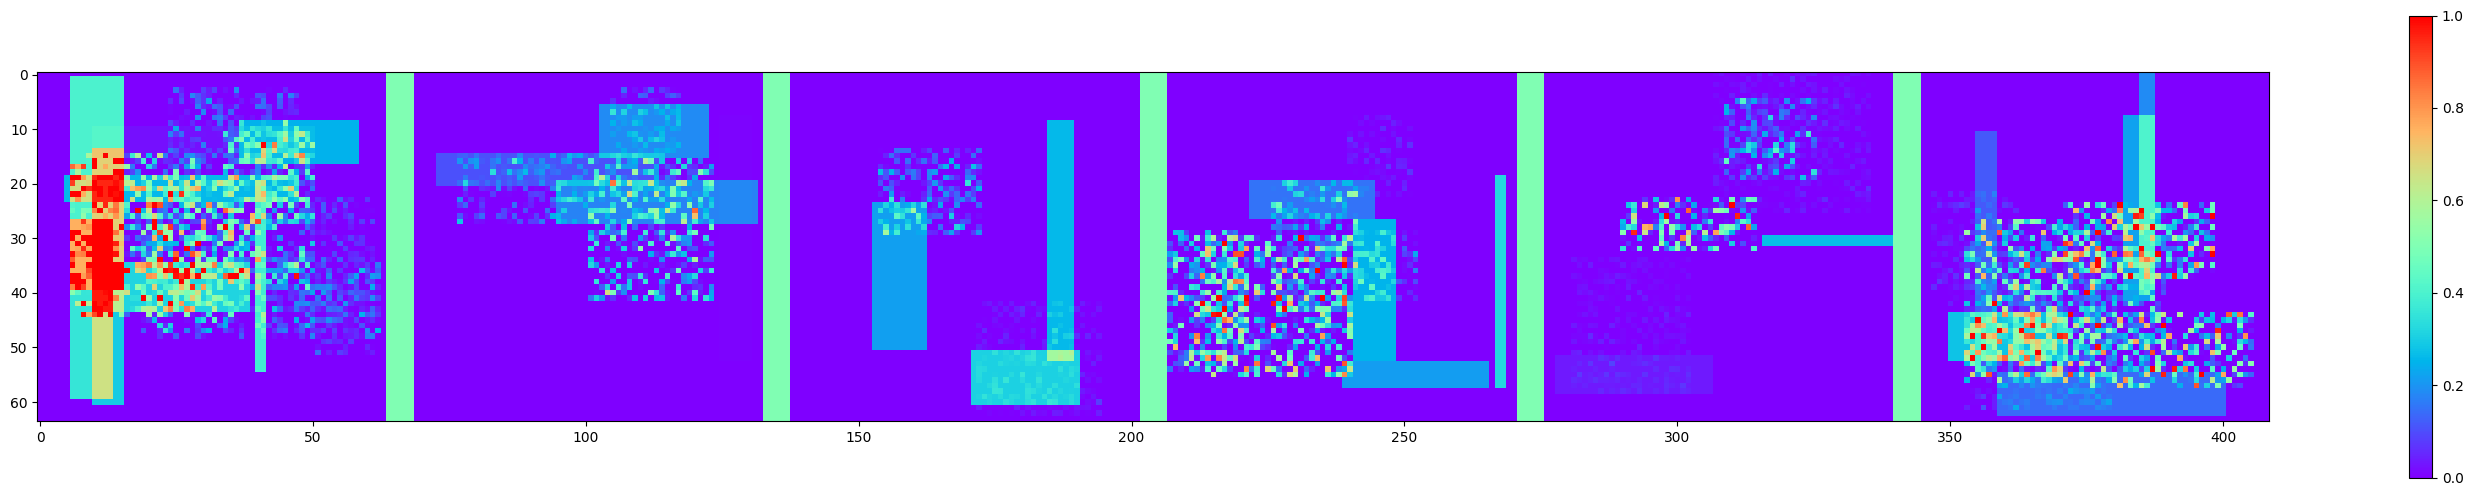

In [31]:
input, targets = gen_dr_test(6)
# Inputs (test)
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# targets (test)
fig1 = plt.figure(0, figsize=(36, 6))
voir_batch2D(targets, 6, fig1, k=0, min_scale=0,max_scale=1)

Ce qu'on voit en effet, c'est que les images test sont plus chargées en figures géométriques. \
Dans la réalité, ce cas de figure se présente lorsque :
 - les données propres au test (ie, représentatives des données à traiter en inférence) sont en trop petit nombre pour être exploitées à l'entraînement
 - un large jeu de données dont les statistiques sont différentes de celles des données d'inférence est disponible.

**Q1** A l'aide d'internet, décrire ce que recouvre le mot clef "domain adaptation" et faites le lien avec l'énoncé.

**Q2** Sur des entraînements courts (20 époques) avec des UNet, montrer que les performances sur le jeu de test sont plus faibles lorsque les données sont entraînées avec gen_dr_train que dans une situation idéale.

**Q3 (Bonus) ** Proposez une méthode simple pour améliorer les performances.

\

---

\

**Exercice 4** Un article important

Parcourir rapidement l'article : https://arxiv.org/abs/1505.04597.
Préciser :
- la nature du problème de Machine Learning abordé.
- quelles méthodes d'augmentation de données sont utilisées.
- l'origine du déséquilibre entre les classes cibles et la façon dont elle il est traité (de manière synthétique).